In [1]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

Load Data

In [3]:
def load_data(dir):
    data = []
    order = []
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            print(os.path.join(dir, file))
            df = pd.read_csv(os.path.join(dir, file),on_bad_lines='skip')
            if not df.empty:
                order.append(int(file[:-4]))
                data.append(df)
    return data, order


try:
    Group1, Group1_order = load_data("/mnt/ArtHeart/Data/Group 1")
    Group2, Group2_order = load_data("/mnt/ArtHeart/Data/Group 2")
    Group3, Group3_order = load_data("/mnt/ArtHeart/Data/Group 3")
except:
    try:
        Group1, Group1_order = load_data("Data/Group 1")
        Group2, Group2_order = load_data("Data/Group 2")
        Group3, Group3_order = load_data("Data/Group 3")
    except:
        Group1, Group1_order = load_data("W:\PhD\ArtHeart\Data\Group 1")
        Group2, Group2_order = load_data("W:\PhD\ArtHeart\Data\Group 2")
        Group3, Group3_order = load_data("W:\PhD\ArtHeart\Data\Group 3")


Data/Group 1/6.csv
Data/Group 1/40.csv
Data/Group 1/7.csv
Data/Group 1/5.csv
Data/Group 1/4.csv
Data/Group 1/1.csv
Data/Group 1/3.csv
Data/Group 1/2.csv
Data/Group 1/37.csv
Data/Group 1/23.csv
Data/Group 1/22.csv
Data/Group 1/36.csv
Data/Group 1/20.csv
Data/Group 1/34.csv
Data/Group 1/35.csv
Data/Group 1/21.csv
Data/Group 1/25.csv
Data/Group 1/31.csv
Data/Group 1/19.csv
Data/Group 1/18.csv
Data/Group 1/30.csv
Data/Group 1/24.csv
Data/Group 1/32.csv
Data/Group 1/26.csv
Data/Group 1/27.csv
Data/Group 1/33.csv
Data/Group 1/16.csv
Data/Group 1/17.csv
Data/Group 1/29.csv
Data/Group 1/15.csv
Data/Group 1/14.csv
Data/Group 1/28.csv
Data/Group 1/10.csv
Data/Group 1/38.csv
Data/Group 1/39.csv
Data/Group 1/11.csv
Data/Group 1/13.csv
Data/Group 1/12.csv
Data/Group 1/9.csv
Data/Group 1/8.csv
Data/Group 2/6.csv
Data/Group 2/40.csv
Data/Group 2/7.csv
Data/Group 2/5.csv
Data/Group 2/4.csv
Data/Group 2/42.csv
Data/Group 2/46.csv
Data/Group 2/1.csv
Data/Group 2/47.csv
Data/Group 2/3.csv
Data/Group 2/44

In [4]:
def interpolate_nan(data):
    for i in range(len(data)):
        df = data[i]
        df['UTC'] = df['UTC'].interpolate()
        data[i] = df
    return data


def cut_to_common_length(data):

    # Interpolate NaN values
    data = interpolate_nan(data)

    # Find the shortest dataframe
    shortest_df = min(data, key=lambda x: len(x))

    # Find the first value of UTC in the shortest dataframe that isn't NaN
    first_utc = shortest_df['UTC'].first_valid_index()
    first_utc_value = shortest_df['UTC'][first_utc]

    # Find the length of the dataframe from that point to the end
    length = len(shortest_df.loc[first_utc:])

    # Cut all dataframes to the same length and reset the index
    for i in range(len(data)):
        df = data[i]

        if first_utc_value in df['UTC'].values:
            match_utc_index = df[df['UTC'] == first_utc_value].index[0]
        else:
            match_utc_index = df.iloc[(df['UTC']-first_utc_value).abs().argsort()[:1]].index[0]

        df = df.loc[match_utc_index:].iloc[:length].reset_index(drop=True)
        data[i] = df
    return data




Group1 = cut_to_common_length(Group1)
Group2 = cut_to_common_length(Group2)
Group3 = cut_to_common_length(Group3)
 
sample_rate = 24

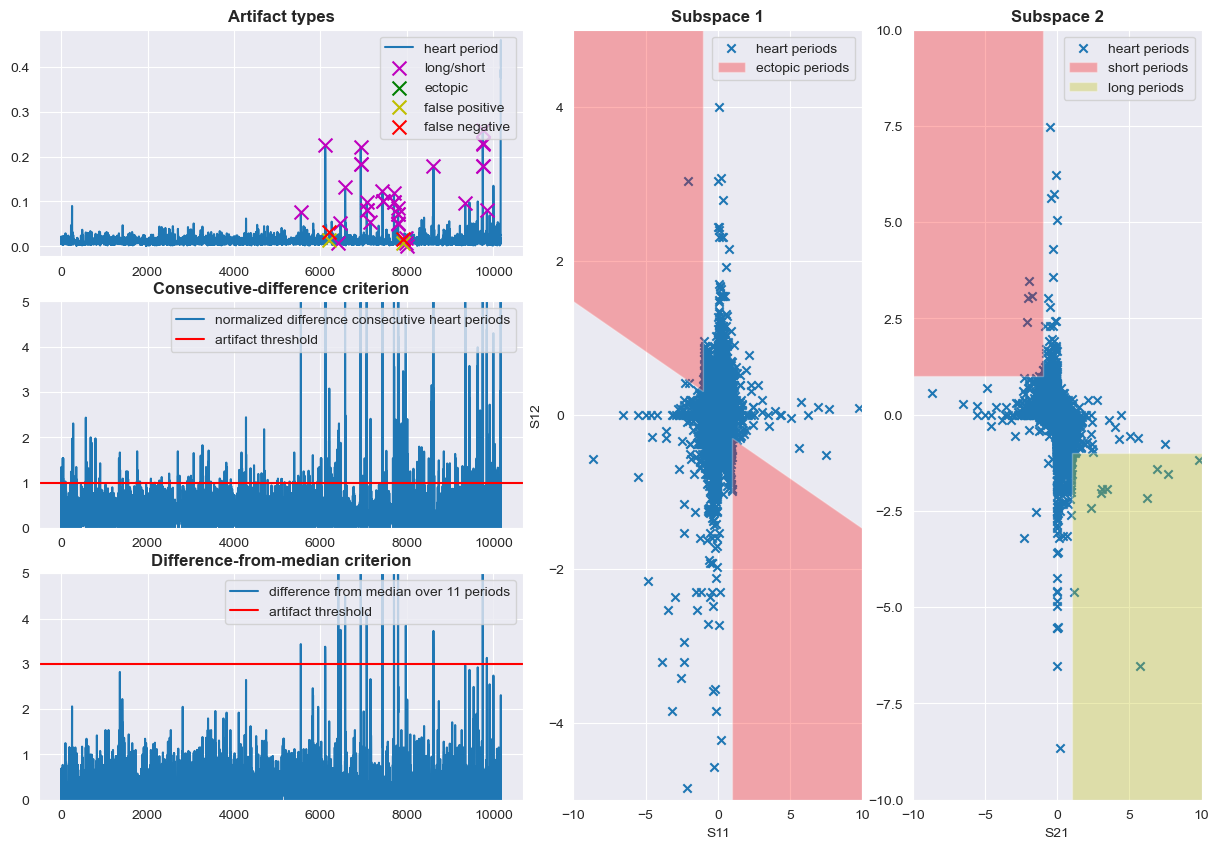

In [5]:
rpeaks_uncorrected  = nk.signal_findpeaks(Group1[0]['DATA'])
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)


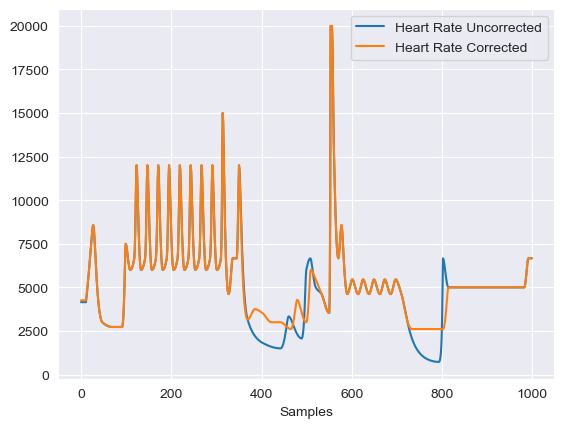

In [6]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

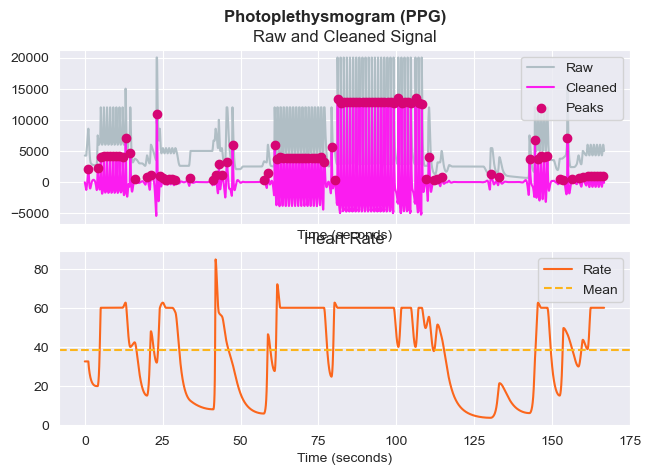

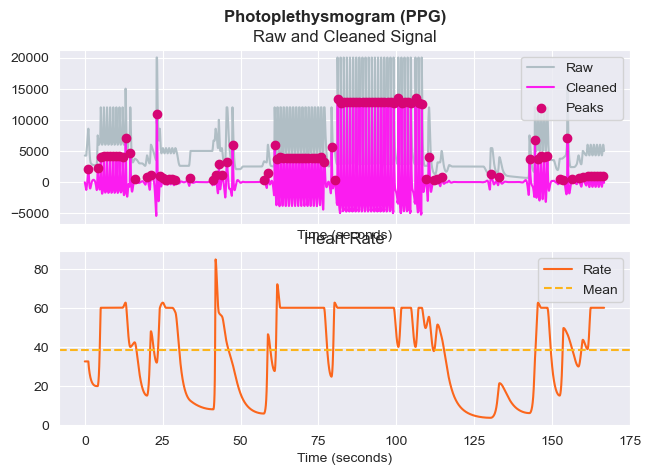

In [7]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals[:4000], sampling_rate=24)

In [8]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=sample_rate)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1   HRV_SDNNI1  \
0       35.09929  1840.551901  2824.349046  1540.998684  2731.529123   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5    HRV_RMSSD  ...  \
0   882.93935  2725.937618   574.63658  2787.98965  3798.690365  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.424259    5.008281     0.471293  0.310101   0.610344    0.495478   

     HRV_CD  HRV_HFD   HRV_KFD   HRV_LZC  
0  0.217467  1.95188  2.282122  0.685578  

[1 rows x 90 columns]


So it looks like the bad sections in the data are affecting the average calculations so now we will cut them out and do the analysis again

In [9]:
def cut_bad_data(raw, windowsize = 100):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn
    
    filtered = []
    
    for i in range(len(raw) // windowsize):
        start = i * windowsize
        end = (i + 1) * windowsize
        sliced = raw[start:end]
        rng = np.max(sliced) - np.min(sliced)
        
        if ((rng >= (0.5 * global_range)) 
            or 
            (np.max(sliced) >= 0.9 * mx) 
            or 
            (np.min(sliced) <= mn + (0.1 * mn))):
            
            for x in sliced:
                filtered.append(np.nan)
        else:
            for x in sliced:
                filtered.append(x)
                
    filtered = np.array(filtered)
    filtered = filtered[~np.isnan(filtered)]
    return filtered

data = Group1[0]['DATA']
data = cut_bad_data(data)

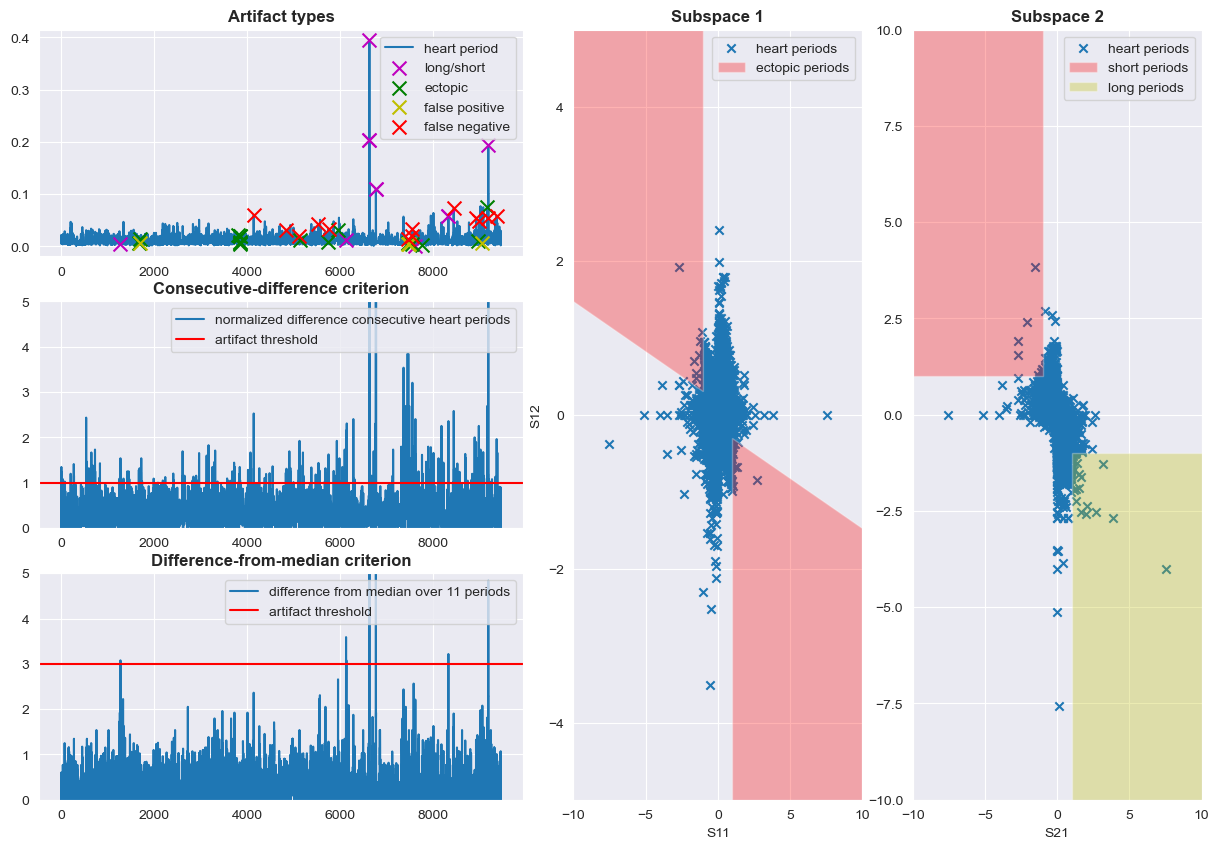

In [10]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

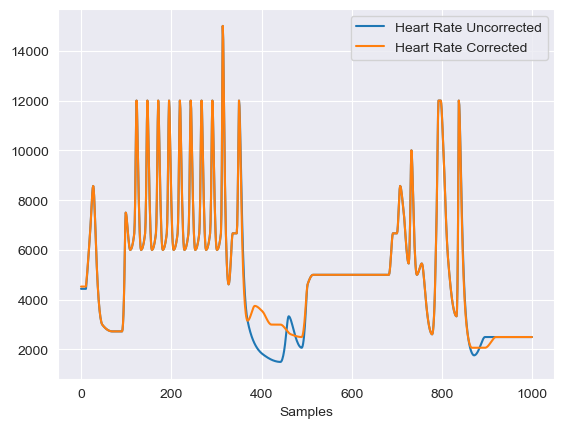

In [11]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

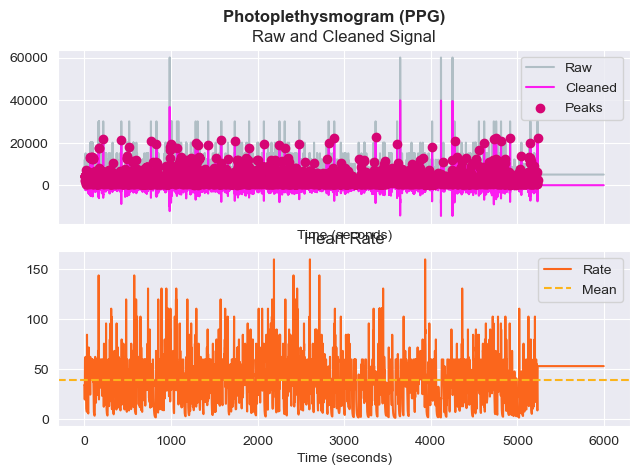

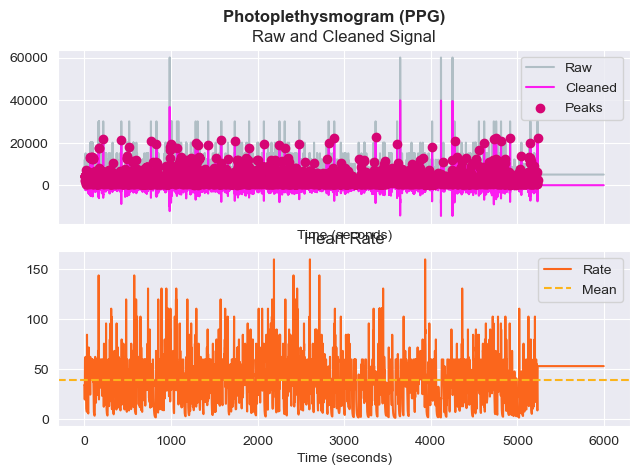

In [12]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [13]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      39.120883  1730.034722  2465.713295  733.930795  2342.548308   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  629.342508  2366.302308  385.330174  2410.324819  3427.963592  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.451993    4.883478     0.487445  0.267627   0.680011    0.556246   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.281661  1.957661  2.427426  0.714993  

[1 rows x 90 columns]


Again not much changed. now I will try removing baseline wander, scaling and filtering along with the removal of bad sections 

In [14]:
import heartpy as hp

def remove_baseline_wander(data):
    data = hp.remove_baseline_wander(data, sample_rate=24)
    data = hp.filter_signal(data, cutoff=[0.7, 3.5], sample_rate=24, order=3, filtertype='bandpass')
    return data

data = cut_bad_data(Group1[0]['DATA'])
data = remove_baseline_wander(data)


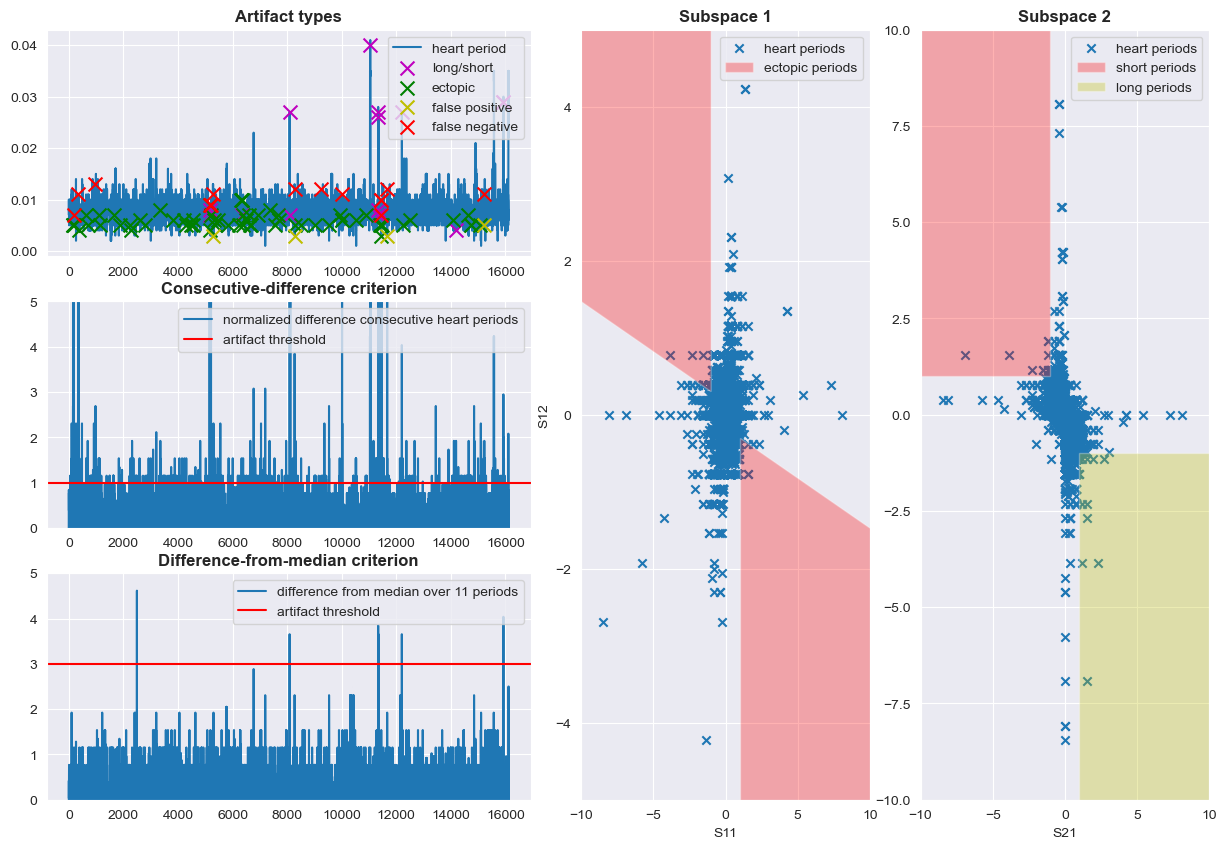

In [15]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

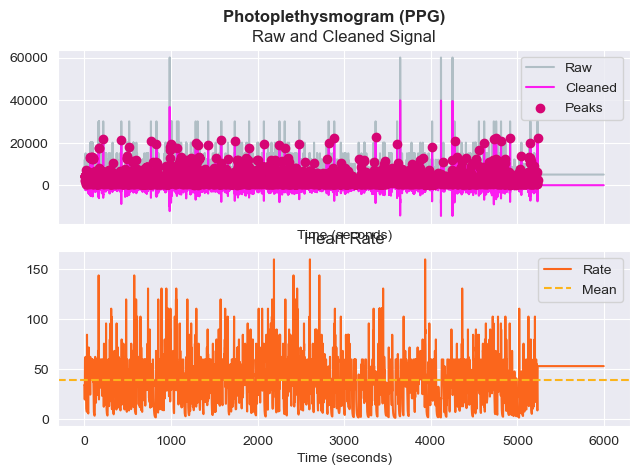

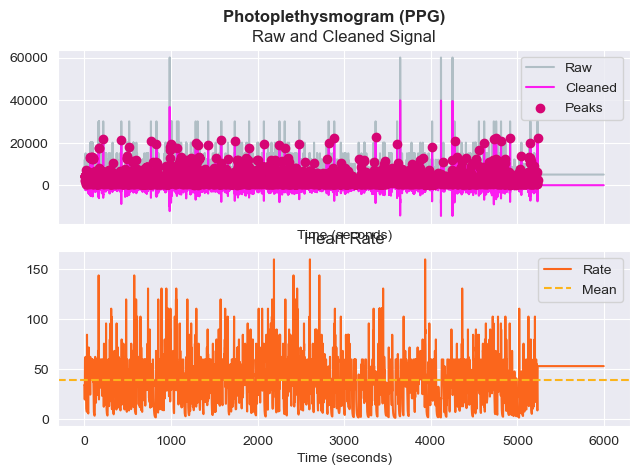

In [16]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [17]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      39.120883  1730.034722  2465.713295  733.930795  2342.548308   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  629.342508  2366.302308  385.330174  2410.324819  3427.963592  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.451993    4.883478     0.487445  0.267627   0.680011    0.556246   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.281661  1.957661  2.427426  0.714993  

[1 rows x 90 columns]


Still not accurate. I will try using a different package for the ppg processing and see if that works

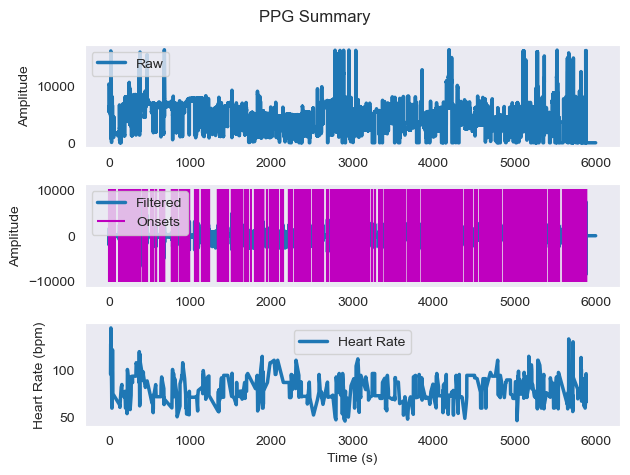

Median HR: 73.11355311355311 bpm


In [18]:
from biosppy.signals import ppg 
data = Group1[0]['DATA']
data = ppg.ppg(signal=data, sampling_rate=24.0, show=True)
median_hr = np.median(data[4])
print("Median HR: "+ str(median_hr) + " bpm")

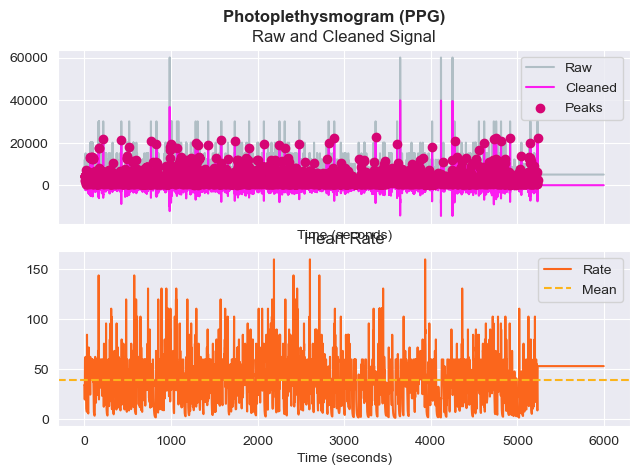

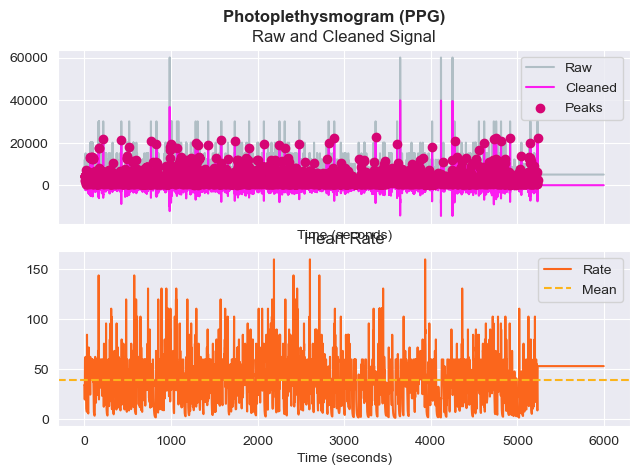

In [19]:
data = data[1]

signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [20]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      39.120883  1730.034722  2465.713295  733.930795  2342.548308   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  629.342508  2366.302308  385.330174  2410.324819  3427.963592  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.451993    4.883478     0.487445  0.267627   0.680011    0.556246   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.281661  1.957661  2.427426  0.714993  

[1 rows x 90 columns]


well thats not ideal... lets build our own process function based on biosppy since it gives a realistic Median HR

In [21]:
def match_interpolate_hr(time,hr_time,hr):
    inter_hr = np.nan*np.ones(len(time)) # initialize interpolated hr array
    
    for i in range(len(hr_time)):
        j = hr_time[i]
        # find index of time that is closest in time to i
        idx = np.argmin(np.abs(time-j))
        inter_hr[int(idx)] = hr[i]
    
    # interpolate missing values

    inter_hr = pd.DataFrame(columns=['hr'], data=inter_hr)
    if pd.isnull(inter_hr['hr'][0]):
        inter_hr['hr'][0] = hr[0]
    inter_hr = inter_hr.interpolate(method='linear')
    inter_hr = inter_hr.values.flatten()
    return inter_hr


def custom_process(data, sample_rate=24):
    clean_data = ppg.ppg(signal=data, sampling_rate=sample_rate, show=False)
    
    raw = data.values
    clean_sig = clean_data[1]
    time = clean_data[0]
    
    
    
    heart_rate = clean_data[4]
    heart_rate_ts = clean_data[3]
    
    hr = match_interpolate_hr(time,heart_rate_ts,heart_rate)
    quality = nk.ecg_quality(clean_sig, sampling_rate=sample_rate)

    # find ppg_peaks by making np array of zeros of length of clean_sig and then set 1 to the values of clean_data[2]
    ppg_peaks = np.zeros(len(clean_sig))
    ppg_peaks[clean_data[2]] = 1
    
    signals = pd.DataFrame({"PPG_Raw": np.array(raw),
                            "PPG_Clean": np.array(clean_sig),
                            "PPG_Peaks": ppg_peaks,
                            "PPG_Rate": np.array(hr),
                            "PPG_Quality": quality})
    
    return signals


signals = custom_process(Group1[0]['DATA'], sample_rate=24)


    


In [22]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1   HRV_SDNNI1  \
0       79.36671  4594.898358  9113.022248  6806.613103  9853.121359   

    HRV_SDANN2  HRV_SDNNI2   HRV_SDANN5   HRV_SDNNI5     HRV_RMSSD  ...  \
0  2857.702308  9555.78069  1474.236494  9195.756714  13053.105312  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.571797    6.017083     0.651499  0.688522   0.732801    0.566262   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.392988  2.009717  2.664738  0.718179  

[1 rows x 90 columns]


Bit Bodged but it has more realistic HRV values. I will try to use this on the whole dataset and see if it works with ML

In [23]:
def process_data(data):
    processed_data = []
    for i in range(len(data)):
        processed_data.append(nk.ppg_analyze(custom_process(data[i]['DATA'], sample_rate=24), sampling_rate=24))
    return processed_data

Group1_processed = process_data(Group1)
Group2_processed = process_data(Group2)
Group3_processed = process_data(Group3)





/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:227: RuntimeWarning: Mean of empty slic

In [31]:
df_group1 = pd.concat(Group1_processed).reset_index(drop=True)
df_group2 = pd.concat(Group2_processed).reset_index(drop=True)
df_group3 = pd.concat(Group3_processed).reset_index(drop=True)

df_order1 = pd.DataFrame(Group1_order, columns=['Order'])
df_order2 = pd.DataFrame(Group2_order, columns=['Order'])
df_order3 = pd.DataFrame(Group3_order, columns=['Order'])

df_order1 = df_order1.reset_index(drop=True)
df_order2 = df_order2.reset_index(drop=True)
df_order3 = df_order3.reset_index(drop=True)

df_complete1 = pd.concat([df_group1, df_order1], axis=1)
df_complete2 = pd.concat([df_group2, df_order2], axis=1)
df_complete3 = pd.concat([df_group3, df_order3], axis=1)


try:
    
    df_complete1.to_csv('/mnt/ArtHeart/Data/group1_processed.csv', index=False)

    df_complete2.to_csv('/mnt/ArtHeart/Data/group2_processed.csv', index=False)

    df_complete3.to_csv('/mnt/ArtHeart/Data/group3_processed.csv', index=False)
    
    
except:
    try:
        
        df_complete1.to_csv('Data/group1_processed.csv', index=False)
        # Save Group2 processed data to CSV
        
        df_complete2.to_csv('Data/group2_processed.csv', index=False)

        df_complete3.to_csv('Data/group3_processed.csv', index=False)
    except:
        
        df_complete1.to_csv('W:\PhD\ArtHeart\Data/group1_processed.csv', index=False)
        
        df_complete2.to_csv('W:\PhD\ArtHeart\Data/group2_processed.csv', index=False)

        df_complete3.to_csv('W:\PhD\ArtHeart\Data/group3_processed.csv', index=False)
